# 1. Reading Data

In [2]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

In [3]:
df = pd.read_csv("clean_data.txt")

In [4]:
df.Malicious.value_counts(normalize=True)

0    0.833684
1    0.166316
Name: Malicious, dtype: float64

# 2. Modelling

In [5]:
X =df.T.tail(34).T
Y =df.T.head(1).T
Y=Y.astype('int')

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [7]:
#function for plotting confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## 5.1 Supervised Modelling (Logistic Regression)

Confusion matrix, without normalization
[[1185    2]
 [   2  222]]


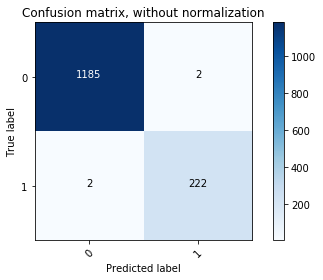

In [37]:
LR = RandomForestClassifier(n_estimators=2000, max_features=0.5).fit(X_train, y_train)
pred_y=LR.predict(X_test)
cm= confusion_matrix(y_test,pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [38]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9910714285714286 0.9910714285714286 0.16849199663016007 99.7165131112686


## 5.2 Unsupervised Modelling - Isolation Forest

In [29]:
#setting threshold for outliers
outliers_fraction = 0.25

Confusion matrix, without normalization
[[2989  575]
 [ 217  494]]


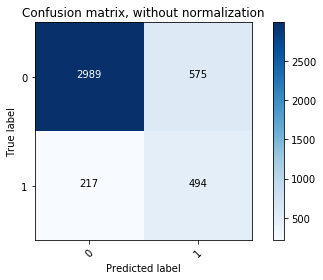

In [32]:
I = IsolationForest(n_estimators=1500, max_features=0.7, contamination=outliers_fraction)
I.fit(X)
X["Iscores"] = I.predict(X)
X["Iscores"] = [1 if x == -1 else 0 for x in X["Iscores"]]
cm= confusion_matrix(Y,X["Iscores"] )
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [33]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.46211412535079516 0.6947960618846695 16.133557800224466 81.47368421052632


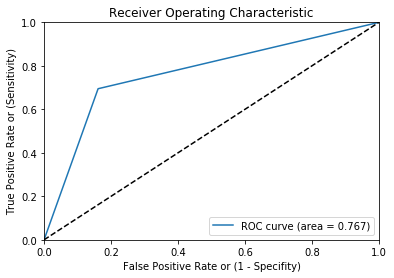

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(Y,X["Iscores"])
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [35]:
auc(fpr,tpr)

0.7667302419412124

## 5.3 Unsupervised Modelling (One-class SVM)

Confusion matrix, without normalization
[[2216 1348]
 [ 267  444]]


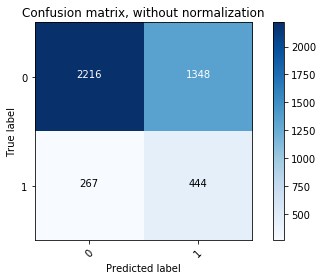

In [41]:
S = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",gamma=0.1)                    
S.fit(X)
X["Sscores"] = S.predict(X)
X["Sscores"] = [1 if x == -1 else 0 for x in X["Sscores"]]
cm= confusion_matrix(Y,X["Sscores"] )
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [42]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.24776785714285715 0.6244725738396625 37.82267115600449 62.22222222222222


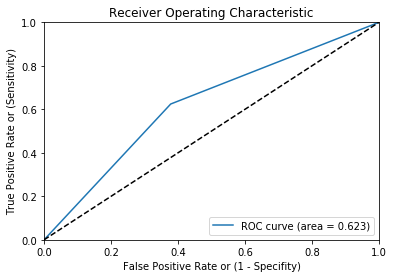

In [44]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(Y,X["Sscores"])
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## 5.3 Unsupervised Modelling (Elliptical Envelope)

Confusion matrix, without normalization
[[3420  144]
 [ 427  284]]


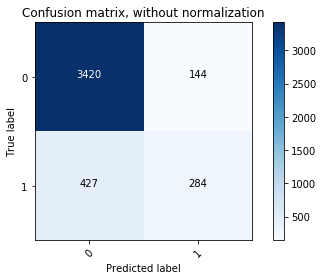

In [45]:
E = EllipticEnvelope()          
E.fit(X)
X["Escores"] = E.predict(X)
X["Escores"] = [1 if x == -1 else 0 for x in X["Escores"]]
cm= confusion_matrix(Y,X["Escores"] )
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [46]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.6635514018691588 0.39943741209563993 4.040404040404041 86.64327485380116


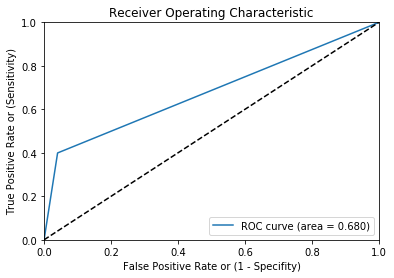

In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(Y,X["Escores"])
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## 5.4 Unsupervised Modelling (Local Outlier Factor)

Confusion matrix, without normalization
[[3295  269]
 [ 552  159]]


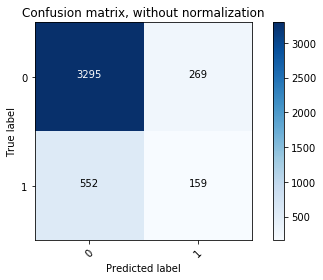

In [48]:
L = LocalOutlierFactor()
L.fit(X)
X["Lscores"] = L.fit_predict(X)
X["Lscores"] = [1 if x == -1 else 0 for x in X["Lscores"]]
cm= confusion_matrix(Y,X["Lscores"] )
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [49]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.37149532710280375 0.22362869198312235 7.547699214365881 80.7953216374269


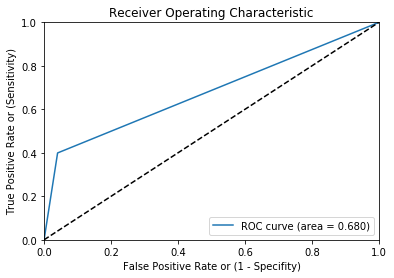

In [50]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(Y,X["Escores"])
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## 5.5 Unsupervised Modelling (Ensemble of the 4)

Confusion matrix, without normalization
[[3456  108]
 [ 451  260]]


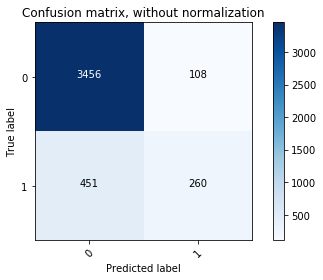

In [8]:
outliers_fraction = 0.25
I = IsolationForest(n_estimators=200, max_features=0.7, contamination=outliers_fraction)
I.fit(X)
X["Iscores"] = I.predict(X)
X["Iscores"] = [1 if x == -1 else 0 for x in X["Iscores"]]
S = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",gamma=0.1)                    
S.fit(X)
X["Sscores"] = S.predict(X)
X["Sscores"] = [1 if x == -1 else 0 for x in X["Sscores"]]
E = EllipticEnvelope()          
E.fit(X)
X["Escores"] = E.predict(X)
X["Escores"] = [1 if x == -1 else 0 for x in X["Escores"]]
L = LocalOutlierFactor()
L.fit(X)
X["Lscores"] = L.fit_predict(X)
X["Lscores"] = [1 if x == -1 else 0 for x in X["Lscores"]]
X["Sum"] = (X["Iscores"] + X["Sscores"] + X["Lscores"] + X["Escores"])/4
X["label"] = [1 if x > 0.5 else 0 for x in X["Sum"]]
cm= confusion_matrix(Y,X["label"] )
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [40]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.6772151898734177 0.3009845288326301 2.861952861952862 85.98830409356725


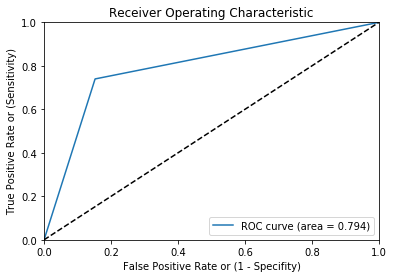

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(Y,X["Iscores"])
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [9]:
Adset = X[["Iscores","Sscores","Lscores","Escores"]]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Adset, Y, test_size=0.33, random_state=42)

## 4.1 Logistic Regression

Confusion matrix, without normalization
[[1131   56]
 [ 124  100]]


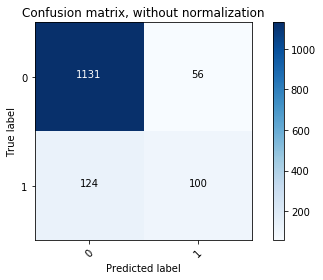

In [11]:
LR = RandomForestClassifier(n_estimators=5000, min_samples_leaf=20, max_features=0.6).fit(X_train, y_train)
pred_y=LR.predict(X_test)
cm= confusion_matrix(y_test,pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [13]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.6410256410256411 0.44642857142857145 4.717775905644482 87.24309000708718


In [15]:
X.T.head(50)

,0,1,2,3,4,5,6,7,8,9,...,4265,4266,4267,4268,4269,4270,4271,4272,4273,4274
startTime,257.648,11455.6,8748.79,3541.2,13172.1,4494.02,6612.58,10612.6,660.746,1635.92,...,86819,86821.4,86852.9,86819.6,86878.4,86878.6,86878.4,86818,104704,105502
flowct,9,3,3,4,1,14,6,4,6,5,...,1,1,1,1,1,29834,1,1,2,1
mean_dest_bytes,16338.1,0,351168,130856,15309,143120,201926,4148.75,2558.5,831.6,...,463,58,58,9936,58,0,509,20734,635.5,561
stdev_dest_bytes,9989.12,0,135900,95264.7,0,153934,89370.1,157.396,2276.37,453.147,...,0,0,0,0,0,0,0,0,37.25,0
mean_dest_pkts,26.8889,3,320.333,135,34,173.357,200.5,15.75,12.1667,13.8,...,5,3,4,10,3,3.99953,1,18,4,4
stdev_dest_pkts,12.0388,0,122.722,92.1667,0,179.348,80.9,2.8125,3.88056,5.77333,...,0,0,0,0,0,0.000593558,0,0,0,0
mean_duration,83.1789,8.48004,46.0092,224.162,99.091,40.9806,22.4439,71.8223,31.2414,96.3669,...,0.623833,31.4941,2.8094,51.1408,0.204775,0.680699,0.003319,132.415,109.331,120.143
stdev_duration,38.494,0.877807,30.4274,140.458,0,41.8313,3.37503,40.3335,20.6511,45.163,...,0,0,0,0,0,0.195953,0,0,3.04859,0
mean_intvl,2.33095,1.03592,0.524554,3042.88,0,259.296,0.0008178,1193.25,185.297,2925.35,...,0,0,0,0,0,0.681471,0,0,2270.61,0
stdev_intvl,3.97232,1.03534,0.52404,4184.35,0,898.221,0.000426675,860.953,202.566,3069.31,...,0,0,0,0,0,0.339354,0,0,0,0
